In [1]:
import pandas as pd
import os, time
import h5py

%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Create timestamp to show when this summary was run
print 'Summary run: ' + time.strftime("%a, %d %b %Y %H:%M:%S")

Summary run: Fri, 02 Feb 2018 18:04:16


In [3]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [4]:
pd.options.display.float_format = '{:0,.0f}'.format

In [5]:
# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'

In [6]:
tod_dict = {
    '5to6': 'AM',
    '6to7': 'AM',
    '7to8': 'AM',
    '8to9': 'AM',
    '9to10': 'Mid-Day',
    '10to14': 'Mid-Day',
    '14to15': 'Mid-Day',
    '15to16': 'PM',
    '16to17': 'PM',
    '17to18': 'PM',
    '18to20': 'Evening',
    '20to5': 'Night'
}

In [7]:
# Load Network Summary sheet from network_summary_detailed
df = pd.read_excel(os.path.join(relative_path,'network/') + r'network_summary_detailed.xlsx',
                  sheetname='Network Summary')
df.rename(columns={'TP_4k': 'Time Period'}, inplace=True)
df['Time Period'] = df['Time Period'].apply(lambda row: row.upper())

## Vehicle Miles Traveled (VMT)

In [8]:
df_tod = df.groupby(['Time Period']).sum()[['arterial_vmt','connectors_vmt','highway_vmt']]
df_tod['VMT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VMT']]

# Save total VMT for later use
total_vmt = df_tod.loc['Total'].values[0]

df_fac = pd.DataFrame(df.sum()[['arterial_vmt','highway_vmt','connectors_vmt']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VMT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,VMT
Facility Type,
arterial_vmt,"5,163,018"
highway_vmt,"21,452,198"
connectors_vmt,"814,846"
Total,"27,430,061"


,VMT
Time Period,
AM,"7,412,315"
EV,"1,789,740"
MD,"9,582,652"
NI,"2,119,282"
PM,"6,526,073"
Total,"27,430,061"


## Vehicle Hours Traveled (VHT)

In [9]:
df_tod = df.groupby(['Time Period']).sum()[['arterial_vht','connectors_vht','highway_vht']]
df_tod['VHT'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['VHT']]

df_fac = pd.DataFrame(df.sum()[['arterial_vht','highway_vht','connectors_vht']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'VHT']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,VHT
Facility Type,
arterial_vht,"150,908"
highway_vht,"416,725"
connectors_vht,"33,592"
Total,"601,224"


,VHT
Time Period,
AM,"172,080"
EV,"35,997"
MD,"199,115"
NI,"42,414"
PM,"151,619"
Total,"601,224"


## Delay

In [10]:
df_tod = df.groupby(['Time Period']).sum()[['arterial_delay','connectors_delay','highway_delay']]
df_tod['Delay'] = df_tod.sum(axis=1)
df_tod.loc['Total'] = df_tod.sum()
df_tod = df_tod[['Delay']]

df_fac = pd.DataFrame(df.sum()[['arterial_delay','highway_delay']])
df_fac = df_fac.reset_index()
df_fac.columns = ['Facility Type', 'Delay']
df_fac.index = df_fac['Facility Type']
df_fac.drop('Facility Type', axis=1, inplace=True)
df_fac.loc['Total'] = df_fac.sum()

display(df_fac)
display(df_tod)

,Delay
Facility Type,
arterial_delay,"19,664"
highway_delay,"54,319"
Total,"73,983"


,Delay
Time Period,
AM,"29,516"
EV,"1,555"
MD,"15,383"
NI,"1,715"
PM,"25,815"
Total,"73,983"


## VMT per Person

In [11]:
# Load Daysim results
trip = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_trip.tsv', sep='\t')
person = pd.read_csv(os.path.join(relative_path,r'daysim/') + r'_person.tsv', sep='\t')

In [12]:
# Load survey results
surveyh5 = h5py.File(os.path.join(relative_path,r'../scripts/summarize/inputs/calibration/survey.h5'))

In [13]:
survey_trip = pd.DataFrame()
survey_person = pd.DataFrame()
for col in surveyh5['Trip'].keys():
    survey_trip[col] = surveyh5['Trip'][col][:]
    
for col in surveyh5['Person'].keys():
    survey_person[col] = surveyh5['Person'][col][:]

In [14]:
pd.options.display.float_format = '{:0,.2f}'.format


# This is average trips
# model_value = trip['trexpfac'].sum()/person['psexpfac'].sum()
# survey_value = survey_trip['trexpfac'].sum()/survey_person['psexpfac'].sum()

_df = pd.DataFrame([total_vmt/person['psexpfac'].sum()])
_df.columns = ['Average VMT per Capita']
_df



,Average VMT per Capita
0,5.65


## Trips per Person

In [15]:
model_result = (trip['trexpfac'].sum()*1.0)/person['psexpfac'].sum()
survey_result = (survey_trip['trexpfac'].sum()*1.0)/survey_person['psexpfac'].sum()

_df = pd.DataFrame([model_result,survey_result])
_df.columns = ['Total Trips per Capita']
_df.index = ['Model', 'Survey']
_df

,Total Trips per Capita
Model,3.88
Survey,4.54


## Average Trip Length

In [16]:
model_result = (trip['travdist']*trip['trexpfac']).sum()/trip['trexpfac'].sum()
survey_result = (survey_trip['travdist']*survey_trip['trexpfac']).sum()/survey_trip['trexpfac'].sum()

_df = pd.DataFrame([model_result,survey_result])
_df.columns = ['Average Trip Length']
_df.index = ['Model','Survey']
_df

,Average Trip Length
Model,6.21
Survey,5.74


## Trip Mode Share

,Model,Survey
mode,,
Walk,19.5%,12.5%
Bike,1.8%,1.3%
SOV,36.1%,40.8%
HOV2,22.0%,22.0%
HOV3+,14.5%,15.8%
Transit,3.9%,4.9%
School Bus,2.0%,2.2%


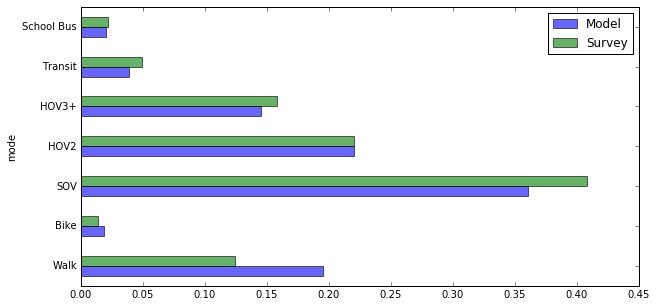

In [17]:
pd.options.display.float_format = '{:,.1%}'.format
model_df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
model_df = model_df.reset_index()
survey_df = survey_trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/survey_trip[['trexpfac']].sum()
survey_df = survey_df.reset_index()
_df = pd.merge(model_df, survey_df, on='mode', how='left')
_df.columns = ['mode','Model', 'Survey']
# _df = trip[['mode','trexpfac']].groupby('mode').sum()[['trexpfac']]/trip[['trexpfac']].sum()
# _df = _df.reset_index()
mode_dict = {0:'Other',1:'Walk',2:'Bike',3:'SOV',4:'HOV2',5:'HOV3+',6:'Transit',8:'School Bus'}
_df.replace({'mode':mode_dict}, inplace=True)
_df.index = _df['mode']
_df.drop('mode', axis=1, inplace=True)
dfplot = _df.drop('Other', axis=0)
dfplot.plot(kind='barh', alpha=0.6, figsize=(10,5))
display(dfplot)